In [ ]:
####  If not GD, run from local starts here ##############

In [75]:
project_path="/FINDER_CM"

In [76]:
# magic line for local jupyter notebooks
%matplotlib inline

In [81]:
import time
import sys,os

import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm


# use old module functions
sys.path.append(f'{project_path}/FINDER-pytorch/code/FINDER_ND_CM/')
from FINDER import FINDER

old_finder = FINDER()

# HXA with maxcc
def HXA(g, method):
        # 'HDA', 'HBA', 'HPRA', 'HCA'
        sol = []
        G = g.copy()
        while (nx.number_of_edges(G)>0):
            if method == 'HDA':
                dc = nx.degree_centrality(G)
            elif method == 'HBA':
                dc = nx.betweenness_centrality(G)
            elif method == 'HCA':
                dc = nx.closeness_centrality(G)
            elif method == 'HPRA':
                dc = nx.pagerank(G)
            keys = list(dc.keys())
            values = list(dc.values())
            maxTag = np.argmax(values)
            node = keys[maxTag]
            sol.append(node)
            G.remove_node(node)
        solution = sol + list(set(g.nodes())^set(sol))
        solutions = [int(i) for i in solution]
        Robustness = old_finder.utils.getRobustness(old_finder.GenNetwork(g), solutions)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness,MaxCCList,solutions

# modified from original EvaluateSol
def EvaluateSol(g, sol_file, strategyID=0, reInsertStep=20):
        #evaluate the robust given the solution, strategyID:0,count;2:rank;3:multipy
        #sys.stdout.flush()
        # g = nx.read_weighted_edgelist(data_test)
        #g = nx.read_gml(data_test)
        g_inner = old_finder.GenNetwork(g)
        print('Evaluating FINDER model')
        print('number of nodes:%d'%nx.number_of_nodes(g))
        print('number of edges:%d'%nx.number_of_edges(g))
        nodes = list(range(nx.number_of_nodes(g)))
        sol = []
        for line in open(sol_file):
            sol.append(int(line))

        sol_left = list(set(nodes)^set(sol))
        if strategyID > 0:
            start = time.time()
            sol_reinsert = old_finder.utils.reInsert(g_inner, sol, sol_left, strategyID, reInsertStep)
            end = time.time()
            print ('reInsert time:%.6f'%(end-start))
        else:
            sol_reinsert = sol
        solution = sol_reinsert + sol_left
        print('number of solution nodes:%d'%len(solution))
        Robustness = old_finder.utils.getRobustness(g_inner, solution)
        MaxCCList = old_finder.utils.MaxWccSzList
        return Robustness, MaxCCList, solution


# load graph from ready to use gml (converted from datasets)
# Network names are: "Digg", "HI-II-14"
# Weight types are: 001, degree, random, zero
def build_graph_path(network_name,weight_type="001"):
    return f"{project_path}/FINDER-pytorch/data/real/cost/{network_name}_{weight_type}.gml"

# load solution files generated by model
# Network names are: "Digg", "HI-II-14"
# Model names are: FINDER_ND_cost, old_FINDER_ND_cost_tf etc.
# step_ratio are: 0.0100, etc.
# Weight types are: 001, degree, random, zero
def build_solution_path(network_name,model_name="FINDER_CN_cost",step_ratio="0.0100",weight_type="001"):
    data_folder=""
    if(weight_type!=""):
        weight_type=f"_{weight_type}"
        data_folder=f"Data{weight_type}/"
    return f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/{data_folder}StepRatio_{step_ratio}/{network_name}{weight_type}.txt"



In [82]:
def get_node_weights(g):
    sum=0.0
    for i,v in g.nodes(data=True):
        sum+=v["weight"]
    return sum

# compute the ratio of cost of removed nodes / totol cost
# TODO, add step (or not, since it's test dataset, step is just trick at training stage)
def get_frac_cost_of_removed_nodes(g,solutions,ND_cost=False,verbose=0):
    num_nodes = nx.number_of_nodes(g) 
    if(ND_cost):
      total_weight = get_node_weights(g)
    else:
      total_weight = g.size()

    g_mod = g.copy()
    if(verbose>0):
        print("\nOriginal # of nodes: ",num_nodes)
        print("Original total weight: ",total_weight)
        print("Solution: ", len(solutions), " = ", solutions , "\n")

    frac_cost_list=[]
    for rm_node in tqdm(solutions):
    #for rm_node in reversed(solutions):
        g_mod.remove_node(rm_node)
        if(ND_cost):
          left_weight = get_node_weights(g_mod)
        else:
          left_weight = g_mod.size()

        frac_cost = (total_weight - left_weight) / total_weight
        frac_cost_list.append(frac_cost)
        if(verbose>1):
            print("Removed node: ", rm_node)
            print("left_weight: ", left_weight)
            print("Frac cost of removed nodes: ", frac_cost)
                
    return frac_cost_list



In [83]:
# plot
from matplotlib import pyplot as plt

cost_model_settings = ['FINDER_ND_cost','FINDER_ND_cost_CM','FINDER_ND_cost_CM_only','old_FINDER_ND_cost_tf','HDA']
model_settings = ['FINDER_ND','FINDER_ND_CM','FINDER_ND_CM_only','old_FINDER_ND_tf','HDA']

def load_from_file(f):
    FINDER_f = open(f, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))

    return scores

def plot_single_graph(dataset_name, model_settings):
    # load network
    g = nx.read_edgelist(f"{project_path}/FINDER-pytorch/data/real/{dataset_name}.txt", nodetype=int)
       
    plt.figure(figsize=(10,8))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            labelname = model_name
            if(model_name=="FINDER_ND_CM"):
                labelname="FINDER_ND_CM + double DQN"
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/{dataset_name}.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/MaxCCList_Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND models f: {dataset_name}")
    plt.show()


def plot_graphs(datasets, model_settings, fig_size=[2,2]):
    fig, axs = plt.subplots(fig_size[0], fig_size[1])
    if(fig_size[1]==2):
      fig.set_size_inches(10, 10)
    else:
      fig.set_size_inches(14, 8)

    ctr=0
    for dataset_name in datasets:             
        # load network
        g = nx.read_edgelist(f"{project_path}/FINDER-pytorch/data/real/{dataset_name}.txt", nodetype=int)

        axs_cell = axs[ctr // fig_size[1], ctr%fig_size[1]]
        ctr+=1

        # load maxcclist directly from scorefiles
        for model_name in model_settings:
            if(model_name=="HDA"):
                # get HDA solution
                HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
                HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
                axs_cell.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
            else:
                labelname = model_name
                if(model_name=="FINDER_ND_CM"):
                    labelname="FINDER_ND_CM + double DQN"
                FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/{dataset_name}.txt")
                FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
                FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/StepRatio_0.0100/MaxCCList_Strategy_{dataset_name}.txt")
                axs_cell.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)

        axs_cell.set_xlabel("fraction of cost")
        axs_cell.set_ylabel("Residual gcc size")
        axs_cell.label_outer()
        axs_cell.set_title(f"{dataset_name}")

    if(fig_size[1]==2):
      axs_cell.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.12),
            fancybox=True, shadow=True, ncol=5)
    else:
      axs_cell.legend(loc='upper center', bbox_to_anchor=(0.2, -0.15),
            fancybox=True, shadow=True, ncol=5)
      axs[1][2].set_visible(False)
    plt.show()

 12%|█████████▋                                                                    | 187/1504 [00:00<00:00, 1869.49it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████                                                                     | 175/1504 [00:00<00:00, 1749.02it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1818.43it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▍                                                                    | 182/1504 [00:00<00:00, 1817.35it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


  2%|█▏                                                                              | 64/4165 [00:00<00:06, 636.76it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 60/4165 [00:00<00:06, 594.02it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 61/4165 [00:00<00:06, 599.97it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 61/4165 [00:00<00:06, 607.13it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1186.98it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:15<00:00, 539.57it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:15<00:00, 525.74it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:15<00:00, 538.95it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:13<00:00, 608.51it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:16<00:00, 537.97it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:16<00:00, 539.18it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:17<00:00, 513.80it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:16<00:00, 544.65it/s]


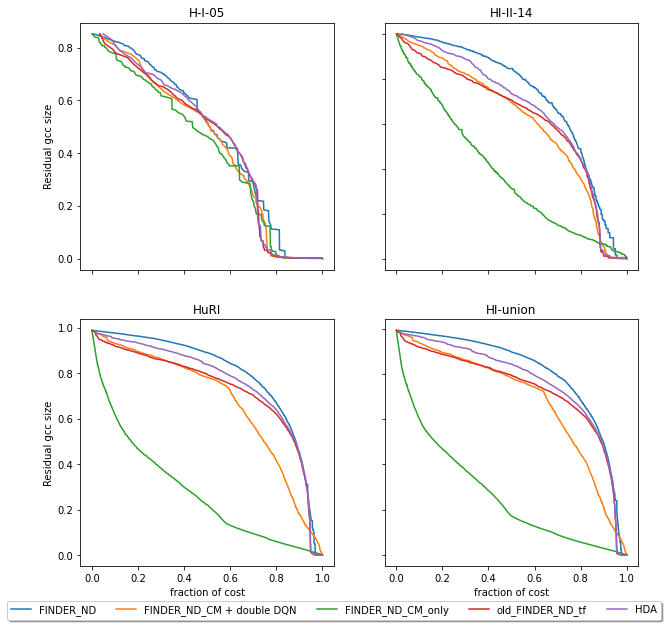

In [84]:
# plot the HuRI family
datasets = ["H-I-05","HI-II-14","HuRI","HI-union"]

plot_graphs(datasets,model_settings,fig_size=[2,2])

  2%|█▊                                                                              | 77/3363 [00:00<00:04, 763.42it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▊                                                                              | 77/3363 [00:00<00:04, 766.55it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▊                                                                              | 78/3363 [00:00<00:04, 777.76it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▊                                                                              | 77/3363 [00:00<00:04, 764.10it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


100%|█████████████████████████████████████████████████████████████████████████████| 3363/3363 [00:02<00:00, 1459.28it/s]


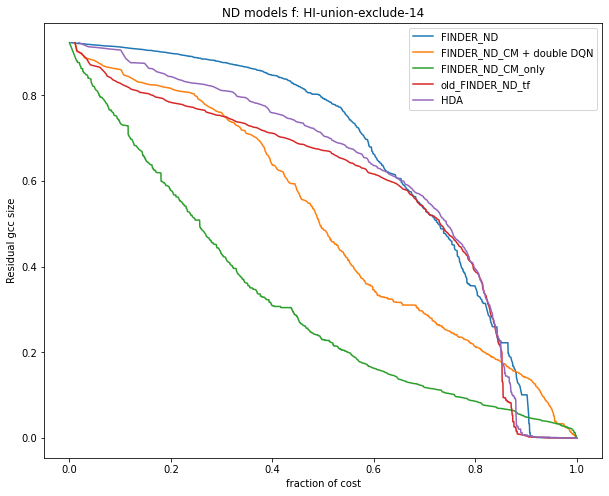

In [85]:
# Plot the strictly-new-dataset
plot_single_graph("HI-union-exclude-14",model_settings)

  0%|                                                                                           | 0/502 [00:00<?, ?it/s]

Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502


  0%|                                                                                           | 0/502 [00:00<?, ?it/s]

Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502


100%|███████████████████████████████████████████████████████████████████████████████| 672/672 [00:00<00:00, 7327.99it/s]


Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672
Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672


100%|███████████████████████████████████████████████████████████████████████████████| 672/672 [00:00<00:00, 7322.26it/s]

Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672
Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672



 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2593.28it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▊                                                            | 259/1132 [00:00<00:00, 2583.28it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|██████████████████▏                                                           | 264/1132 [00:00<00:00, 2634.22it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 260/1132 [00:00<00:00, 2595.28it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


  1%|▌                                                                               | 44/5956 [00:00<00:13, 435.19it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 43/5956 [00:00<00:13, 428.49it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 43/5956 [00:00<00:13, 425.97it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 43/5956 [00:00<00:13, 429.32it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


100%|██████████████████████████████████████████████████████████████████████████████| 5956/5956 [00:06<00:00, 860.52it/s]


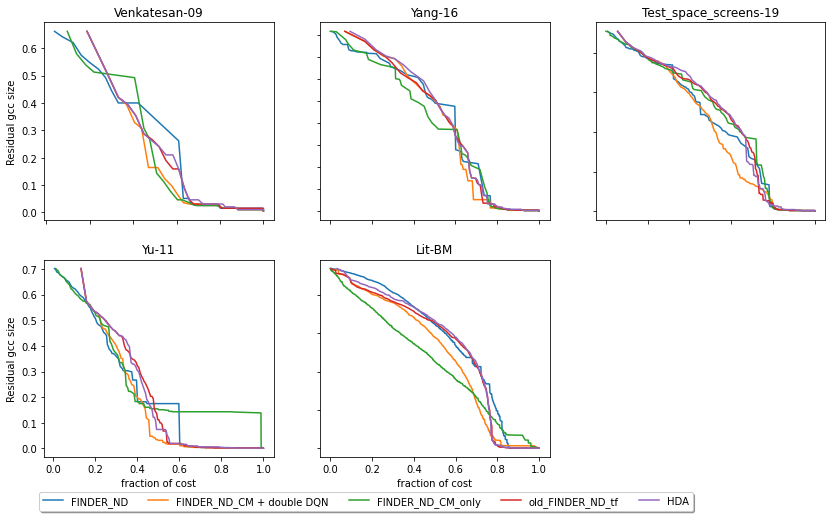

In [86]:
# plot the other datasets
datasets = ["Venkatesan-09","Yang-16","Test_space_screens-19","Yu-11","Lit-BM"]

plot_graphs(datasets,model_settings,fig_size=[2,3])

In [87]:
def plot_single_cost_graph(dataset_name, model_settings):
    # load network
    g = nx.read_gml(f"{project_path}/FINDER-pytorch/data/real/cost/{dataset_name}_degree.gml",destringizer=int)
       
    plt.figure(figsize=(12,12))
    
    # load maxcclist directly from scorefiles
    for model_name in model_settings:
        if(model_name=="HDA"):
            # get HDA solution
            HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
            #print("From HDA:",HDA_robustness, HDA_maxcclist[0:5],HDA_solutions[0:5])
            HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
            plt.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
        else:
            labelname = model_name
            if(model_name=="FINDER_ND_cost_CM"):
                labelname="FINDER_ND_cost_CM + double DQN"
            FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/{dataset_name}_degree.txt")
            FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
            FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/MaxCCList__Strategy_{dataset_name}.txt")
            plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)
            #plt.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=f"{model_name} from file")

    plt.legend()
    plt.xlabel("fraction of cost")
    plt.ylabel("Residual gcc size")
    plt.title(f"ND_cost models for dataset: {dataset_name}")
    plt.show()

def plot_cost_graphs(datasets, model_settings, fig_size=[2,2]):
    fig, axs = plt.subplots(fig_size[0], fig_size[1])
    if(fig_size[1]==2):
      fig.set_size_inches(10, 10)
    else:
      fig.set_size_inches(14, 8)

    ctr=0
    for dataset_name in datasets:             
        # load network
        g = nx.read_gml(f"{project_path}/FINDER-pytorch/data/real/cost/{dataset_name}_degree.gml",destringizer=int)

        axs_cell = axs[ctr // fig_size[1], ctr%fig_size[1]]
        ctr+=1

        # load maxcclist directly from scorefiles
        for model_name in model_settings:
            if(model_name=="HDA"):
                # get HDA solution
                HDA_robustness, HDA_maxcclist,HDA_solutions  = HXA(g, "HDA")
                HDA_frac_cost_list = get_frac_cost_of_removed_nodes(g,HDA_solutions)
                axs_cell.plot(HDA_frac_cost_list, HDA_maxcclist, label=model_name)
            else:
                labelname = model_name
                if(model_name=="FINDER_ND_cost_CM"):
                  labelname="FINDER_ND_cost_CM + double DQN"
                FINDER_robustness, FINDER_maxcclist,FINDER_solutions = EvaluateSol(g, f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/{dataset_name}_degree.txt")
                FINDER_frac_cost_list = get_frac_cost_of_removed_nodes(g,FINDER_solutions)
                FINDER_maxcclist2=load_from_file(f"{project_path}/FINDER-pytorch/code/results/{model_name}/real/Data_degree/StepRatio_0.0100/MaxCCList__Strategy_{dataset_name}.txt")
                axs_cell.plot(FINDER_frac_cost_list, FINDER_maxcclist2, label=labelname)

        axs_cell.set_xlabel("fraction of cost")
        axs_cell.set_ylabel("Residual gcc size")
        axs_cell.label_outer()
        axs_cell.set_title(f"{dataset_name}")

    if(fig_size[1]==2):
      axs_cell.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.12),
            fancybox=True, shadow=True, ncol=5)
    else:
      axs_cell.legend(loc='upper center', bbox_to_anchor=(0.2, -0.15),
            fancybox=True, shadow=True, ncol=5)
      axs[1][2].set_visible(False)
    plt.show()

 12%|█████████▊                                                                    | 188/1504 [00:00<00:00, 1879.82it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▌                                                                    | 185/1504 [00:00<00:00, 1848.86it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▋                                                                    | 186/1504 [00:00<00:00, 1854.25it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


 12%|█████████▋                                                                    | 186/1504 [00:00<00:00, 1856.61it/s]

Evaluating FINDER model
number of nodes:1504
number of edges:2565
number of solution nodes:1504


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 615.75it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  1%|█▏                                                                              | 62/4165 [00:00<00:06, 616.36it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 63/4165 [00:00<00:06, 621.18it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


  2%|█▏                                                                              | 63/4165 [00:00<00:06, 622.78it/s]

Evaluating FINDER model
number of nodes:4165
number of edges:13087
number of solution nodes:4165


100%|█████████████████████████████████████████████████████████████████████████████| 4165/4165 [00:03<00:00, 1233.66it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:23<00:00, 353.22it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:18<00:00, 457.91it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:14<00:00, 575.03it/s]


Evaluating FINDER model
number of nodes:8245
number of edges:52068
number of solution nodes:8245


100%|██████████████████████████████████████████████████████████████████████████████| 8245/8245 [00:13<00:00, 606.75it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:17<00:00, 522.92it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:17<00:00, 519.58it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:17<00:00, 515.74it/s]


Evaluating FINDER model
number of nodes:9060
number of edges:63242
number of solution nodes:9060


100%|██████████████████████████████████████████████████████████████████████████████| 9060/9060 [00:17<00:00, 524.04it/s]


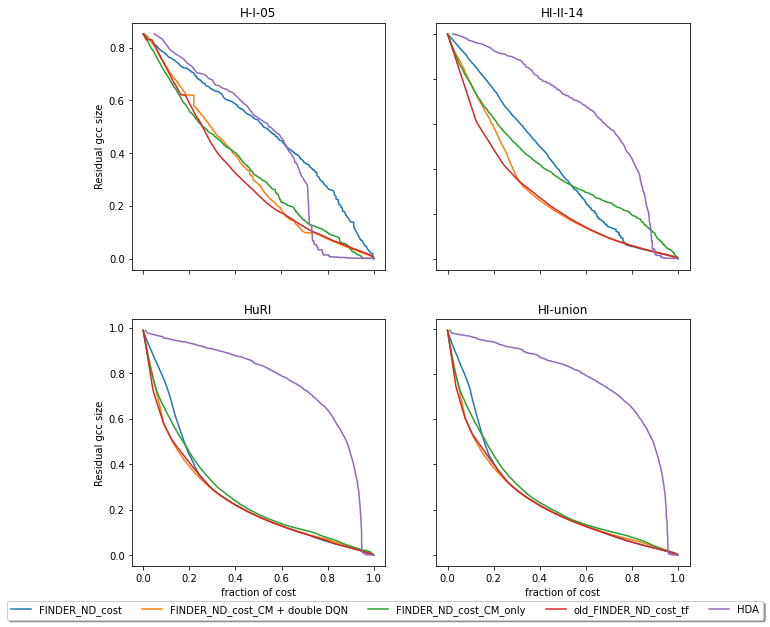

In [88]:
# plot the HuRI family
datasets = ["H-I-05","HI-II-14","HuRI","HI-union"]

plot_cost_graphs(datasets,cost_model_settings,fig_size=[2,2])

  2%|█▉                                                                              | 80/3363 [00:00<00:04, 794.47it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▊                                                                              | 75/3363 [00:00<00:04, 743.17it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▋                                                                              | 69/3363 [00:00<00:04, 679.30it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


  2%|█▌                                                                              | 68/3363 [00:00<00:04, 670.26it/s]

Evaluating FINDER model
number of nodes:3363
number of edges:10056
number of solution nodes:3363


100%|█████████████████████████████████████████████████████████████████████████████| 3363/3363 [00:02<00:00, 1538.06it/s]


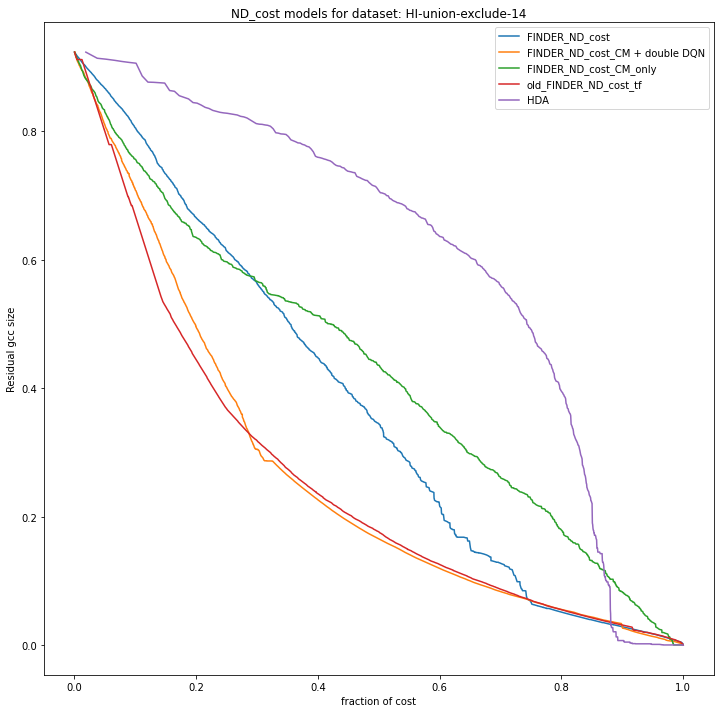

In [89]:
# Plot the strictly-new-dataset
plot_single_cost_graph("HI-union-exclude-14",cost_model_settings)

  0%|                                                                                           | 0/502 [00:00<?, ?it/s]

Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:195
number of edges:187
number of solution nodes:195
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 9831.58it/s]


Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502
Evaluating FINDER model
number of nodes:502
number of edges:717
number of solution nodes:502


100%|███████████████████████████████████████████████████████████████████████████████| 672/672 [00:00<00:00, 7568.73it/s]

Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672
Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672



  0%|                                                                                           | 0/672 [00:00<?, ?it/s]

Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672
Evaluating FINDER model
number of nodes:672
number of edges:1159
number of solution nodes:672


 23%|██████████████████▎                                                           | 266/1132 [00:00<00:00, 2652.39it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▊                                                            | 259/1132 [00:00<00:00, 2584.32it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 23%|█████████████████▉                                                            | 261/1132 [00:00<00:00, 2604.90it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


 24%|██████████████████▍                                                           | 267/1132 [00:00<00:00, 2663.15it/s]

Evaluating FINDER model
number of nodes:1132
number of edges:1126
number of solution nodes:1132


  1%|▌                                                                               | 45/5956 [00:00<00:13, 448.12it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 46/5956 [00:00<00:13, 451.76it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 45/5956 [00:00<00:13, 447.07it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


  1%|▌                                                                               | 45/5956 [00:00<00:13, 445.56it/s]

Evaluating FINDER model
number of nodes:5956
number of edges:12758
number of solution nodes:5956


100%|██████████████████████████████████████████████████████████████████████████████| 5956/5956 [00:06<00:00, 878.60it/s]


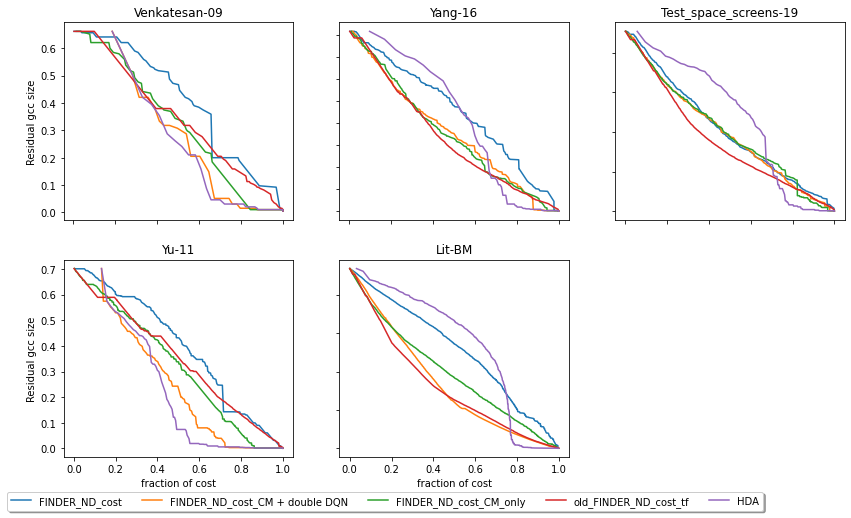

In [90]:
# plot the other datasets
datasets = ["Venkatesan-09","Yang-16","Test_space_screens-19","Yu-11","Lit-BM"]

plot_cost_graphs(datasets,cost_model_settings,fig_size=[2,3])